# Imports

In [1]:
! pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datasets import load_dataset
import gensim.downloader as api
from tensorflow.keras import layers, models , optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Dataset

Dataset :


*   dair_ai/emotion:
    - [here](https://huggingface.co/datasets/dair-ai/emotion)
    - 6 emotions

*   go emotion:
    - [here](https://huggingface.co/datasets/google-research-datasets/go_emotions/blob/main/README.md)
    - 27 emotions + Neutral



In [3]:
#Global variables
USE_goemotion = False
if USE_goemotion  :
  NUM_class = 28
  data_name = "google-research-datasets/go_emotions"
  RECALL=tf.keras.metrics.Recall()
  PRECISION=tf.keras.metrics.Precision()
  AUC=tf.keras.metrics.AUC()
else :
  NUM_class = 6
  data_name= "dair-ai/emotion"

In [4]:
class DatasetLoader:
    def __init__(self, dataset_name="dair-ai/emotion", embedding_dim=300):
        """
        Load and preprocess the dataset.

        Parameters:
        - dataset_name: name of the Hugging Face dataset (default is "dair-ai/emotion").
        - embedding_dim: dimension of the word embeddings (default is 300 for Word2Vec).
        """
        self.dataset_name = dataset_name
        self.embedding_dim = embedding_dim
        self.dataset = load_dataset(dataset_name)

        # Load pre-trained Word2Vec model from Gensim
        self.model = api.load("word2vec-google-news-300")

    def preprocess(self):
        """
        Preprocess the text and convert it into embedding vectors.
        """
        if USE_goemotion :
          def preprocess_go_emotions(split):
            texts = self.dataset[split]['text']
            # Create a binary matrix for the labels
            num_classes = len(self.dataset['train'].features['labels'].feature.names)  # Total number of labels
            labels = np.zeros((len(self.dataset[split]['labels']), num_classes), dtype=np.float32)
            for i, label_list in enumerate(self.dataset[split]['labels']):
                for label in label_list:  # Each label in the list is a class index
                    labels[i][label] = 1  # Set corresponding index to 1
            return texts, labels

          train_texts,train_labels = preprocess_go_emotions('train')
          val_texts,val_labels = preprocess_go_emotions('validation')
          test_texts,test_labels = preprocess_go_emotions('test')
        else :
          train_texts = self.dataset['train']['text']
          val_texts = self.dataset['validation']['text']
          test_texts = self.dataset['test']['text']
          train_labels = self.dataset['train']['label']
          val_labels = self.dataset['validation']['label']
          test_labels = self.dataset['test']['label']
          # Label encoding
          label_encoder = LabelEncoder()
          train_labels = label_encoder.fit_transform(train_labels)
          val_labels = label_encoder.transform(val_labels)
          test_labels = label_encoder.transform(test_labels)
          # One-hot encode labels for multi-class classification
          train_labels = to_categorical(train_labels, num_classes=NUM_class)
          val_labels = to_categorical(val_labels, num_classes=NUM_class)
          test_labels = to_categorical(test_labels, num_classes=NUM_class)

        # Convert text to Word2Vec embeddings
        def get_word2vec_embeddings(texts):
            embeddings = []
            for text in texts:
                words = text.split()
                vector = np.zeros(self.embedding_dim)
                valid_words = 0
                for word in words:
                    try:
                        vector += self.model[word]  # Add the embedding of each word
                        valid_words += 1
                    except KeyError:
                        continue  # Skip words not in the vocabulary
                # Average the word vectors (if no valid words, return a zero vector)
                if valid_words > 0:
                    vector /= valid_words
                embeddings.append(vector)
            return np.array(embeddings)

        X_train = get_word2vec_embeddings(train_texts)
        X_val = get_word2vec_embeddings(val_texts)
        X_test = get_word2vec_embeddings(test_texts)



        return X_train, X_val, train_labels, val_labels, X_test, test_labels

In [5]:
# Load the dataset
dataset_loader = DatasetLoader(dataset_name=data_name)
X_train, X_val, y_train, y_val, X_test, y_test = dataset_loader.preprocess()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

[==================================================] 100.0% 1662.8/1662.8MB downloaded


# Model Implementation

In [21]:
class TextClassifier:
    def __init__(self, input_dim, num_classes, embedding_dim=300,optimizer=None,hidden_layers=[128, 64, 32],
                 dropout_rates=[0.5, 0.4, 0.3]):
        """
        Initialize the MLP model for text classification.

        Parameters:
        - input_dim: dimension of the input vectors (e.g., 300 for Word2Vec).
        - num_classes: number of output classes.
        - embedding_dim: dimension of word embeddings (default is 300).
        """
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.optimizer = optimizer if optimizer else optimizers.Adam(learning_rate=0.001)
        self.dropout_rates = dropout_rates
        self.hidden_layers = hidden_layers

        self.model = self.build_model()

    def build_model(self):
        """
        Build the MLP model.
        """
        model = models.Sequential()

        # Input layer (input_dim size)
        model.add(layers.InputLayer(shape=(self.input_dim,)))

        # Hidden layers
        for units, dropout_rate in zip(self.hidden_layers, self.dropout_rates):
            model.add(layers.Dense(units, activation='relu'))
            model.add(layers.BatchNormalization())  # Batch normalization after each Dense layer
            model.add(layers.Dropout(dropout_rate))  # Dropout for regularization

        # Output layer
        if USE_goemotion :
          model.add(layers.Dense(self.num_classes, activation='sigmoid'))
          loss_name = 'binary_crossentropy'
          metrics=['accuracy', RECALL,PRECISION, AUC]
          #metrics=['accuracy', tf.keras.metrics.Recall(),tf.keras.metrics.Precision(), tf.keras.metrics.AUC()]
        else :
          model.add(layers.Dense(self.num_classes, activation='softmax'))
          loss_name = 'categorical_crossentropy'
          metrics= ['accuracy']

        # Compile the model
        model.compile(optimizer='adam',
                      loss=loss_name,
                      metrics=metrics)

        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        """
        Train the model.

        Parameters:
        - X_train, y_train: training data.
        - X_val, y_val: validation data.
        - epochs: number of epochs.
        - batch_size: batch size.
        """
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
        return history

    def evaluate(self, X_test, y_test):
        """
        Evaluate the model on the test data.
        """
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=2)
        print(f"Test Loss: {loss}")
        print(f"Test Accuracy: {accuracy * 100:.2f}%")
        return loss, accuracy

    def predict(self, X):
        """
        Predict classes for new data.
        """
        return self.model.predict(X)

# Train

In [22]:
#Hyperparameters :

if USE_goemotion :
  epoch = 30
  batch = 64
  hidden_layers = [512,128, 64, 32]
  dropout_rates = [0.3,0.2,0.1, 0.1]


  b1=0.9
  b2=0.99
  wd=1e-4

  # Define an exponential decay schedule
  lr_schedule = ExponentialDecay(
      initial_learning_rate=0.01,  # Starting learning rate
      decay_steps=1000,           # Decay frequency
      decay_rate=0.99,            # Factor by which the learning rate decreases
      staircase=True              # If True, learning rate decreases in discrete steps
  )
else :
  epoch = 30
  batch = 32
  hidden_layers = [128,128, 64, 32]
  dropout_rates = [0.3,0.2, 0.2, 0.1]


  b1=0.9
  b2=0.99
  wd=1e-5

  # Define an exponential decay schedule
  lr_schedule = ExponentialDecay(
      initial_learning_rate=0.01,  # Starting learning rate
      decay_steps=1000,           # Decay frequency
      decay_rate=0.96,            # Factor by which the learning rate decreases
      staircase=True              # If True, learning rate decreases in discrete steps
  )


In [23]:
# Create the text classifier model

optimizer = optimizers.Adam(learning_rate=lr_schedule,beta_1=b1,beta_2=b2,weight_decay=wd)
classifier = TextClassifier(input_dim=300, num_classes=NUM_class,hidden_layers=hidden_layers,dropout_rates=dropout_rates,optimizer=optimizer)

# Display the model architecture
classifier.model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 128)                 │          38,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,982 (261.65 KB)

 Trainable params: 66,278 (258.90 KB)

 Non-trainable params: 704 (2.75 KB)

In [24]:
# Train the model
history = classifier.train(X_train, y_train, X_val, y_val, epochs=epoch, batch_size=batch)

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3669 - loss: 1.7625 - val_accuracy: 0.6080 - val_loss: 1.1192
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5836 - loss: 1.1419 - val_accuracy: 0.6115 - val_loss: 1.0559
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6297 - loss: 1.0134 - val_accuracy: 0.6510 - val_loss: 0.9362
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6467 - loss: 0.9513 - val_accuracy: 0.6760 - val_loss: 0.8850
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6580 - loss: 0.9187 - val_accuracy: 0.6935 - val_loss: 0.8323
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6680 - loss: 0.8999 - val_accuracy: 0.6715 - val_loss: 0.8804
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6721 - loss: 0.8669 - val_accuracy: 0.6900 - val_loss: 0.8222
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6807 - loss: 0.8486 - val_accuracy: 0.

In [25]:
def plot_metrics(history):
  if USE_goemotion:
    plt.figure(figsize=(12, 8))
    # Plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # Plot recall
    plt.subplot(2, 2, 2)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    # Plot precision
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    # Plot F1 score (You can calculate it directly from recall and precision if needed)
    plt.subplot(2, 2, 4)
     # Calculer le F1-score à partir de la précision et du rappel
    # Les précisions et rappels doivent être des scalaires
    train_f1 = np.array([2 * (p * r) / (p + r + np.finfo(float).eps)
                         for p, r in zip(history.history['precision'], history.history['recall'])])

    val_f1 = np.array([2 * (p * r) / (p + r + np.finfo(float).eps)
                       for p, r in zip(history.history['val_precision'], history.history['val_recall'])])
    plt.plot(train_f1, label='Training F1 Score')
    plt.plot(val_f1, label='Validation F1 Score')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.tight_layout()
    plt.show()
  else:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

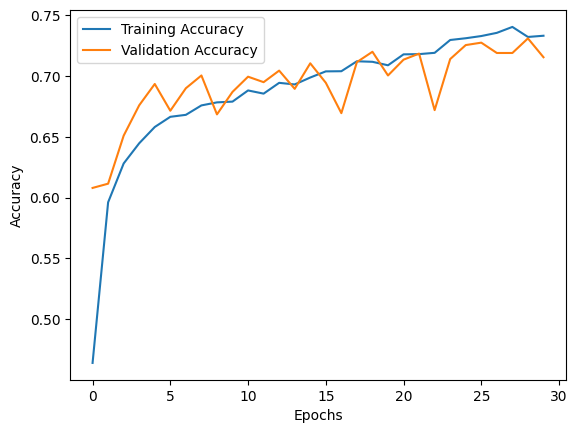

In [26]:
# Visualize the training curves
plot_metrics(history)

# Test

In [27]:
# Evaluate the model
if not USE_goemotion:
  classifier.evaluate(X_test, y_test)

63/63 - 0s - 2ms/step - accuracy: 0.7125 - loss: 0.7399
Test Loss: 0.7398556470870972
Test Accuracy: 71.25%


In [28]:
if USE_goemotion :
  class_names = [
      'admiration',
      'amusement',
      'anger',
      'annoyance',
      'approval',
      'caring',
      'confusion',
      'curiosity',
      'desire',
      'disappointment',
      'disapproval',
      'disgust',
      'embarrassment',
      'excitement',
      'fear',
      'gratitude',
      'grief',
      'joy',
      'love',
      'nervousness',
      'optimism',
      'pride',
      'realization',
      'relief',
      'remorse',
      'sadness',
      'surprise',
      'neutral']
else :
  class_names = ['anger', 'fear', 'joy ', 'love' ,'sadness', 'surprise']

model = classifier
num_samples = 10

data = dataset_loader.dataset['test']['text']


# Randomly select samples from the test set
indices = np.random.choice(len(X_test), num_samples, replace=False)
x_text = [data[i] for i in indices]
X_subset = X_test[indices]
y_true_subset = y_test[indices]

# Get predictions from the model
y_pred_prob = model.predict(X_subset)  # Predict probabilities

if USE_goemotion:

  # Threshold for multilabel prediction (you can adjust the threshold)
  threshold = 0.5  # If probability > 0.5, label is 1; otherwise 0

  # Convert probabilities to binary labels (1 or 0) using the threshold
  y_pred_labels = (y_pred_prob > threshold).astype(int)

  # Display predictions vs true labels
  print("Sample Predictions:")
  for i in range(num_samples):
      print(f"Sample {i + 1}:")
      print(f" Text: {x_text[i]}")

      # Get the true labels and predicted labels as a list of class names
      true_labels = [class_names[j] for j in range(len(class_names)) if y_true_subset[i][j] == 1]
      predicted_labels = [class_names[j] for j in range(len(class_names)) if y_pred_labels[i][j] == 1]

      print(f"  True Labels: {', '.join(true_labels)}")
      print(f"  Predicted Labels: {', '.join(predicted_labels)}")

      # If no label has a probability greater than threshold, take the one with the highest probability
      if np.sum(y_pred_labels[i]) == 0:  # No label predicted as 1 (probabilities <= threshold)
          max_prob_index = np.argmax(y_pred_prob[i])  # Get the class with the highest probability
          max_prob_label = class_names[max_prob_index]
          print(f"  No label with prob > 0.5. Most likely class: {max_prob_label} with prob {y_pred_prob[i][max_prob_index]:.2f}")
      else:
          # Display probability only for the classes where y_true or y_pred is 1
          for j in range(len(class_names)):
              if y_true_subset[i][j] == 1:  # Show only the labels that are 1 in the true labels
                  print(f"  {class_names[j]}: True={y_true_subset[i][j]}, Pred={y_pred_prob[i][j]:.2f}")
      print("-" * 40)

else:

  y_pred_labels = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices
  y_true_labels = np.argmax(y_true_subset, axis=1)  # Convert true one-hot labels to class indices

  # Display predictions vs true labels
  print("Sample Predictions:")
  for i in range(num_samples):
    print(f"Sample {i + 1}:")
    print(f" Text: {x_text[i]}")
    print(f"  True Label: {class_names[y_true_labels[i]]}")
    print(f"  Predicted: {class_names[y_pred_labels[i]]}")
    print(f"  Confidence: {np.max(y_pred_prob[i]):.2f}")
    print("-" * 40)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Sample Predictions:
Sample 1:
 Text: i remember feeling thrilled to use my nursing skills relieved that i could have a few days out of the house and i remember that at first it was hard but then it was no problem
  True Label: fear
  Predicted: fear
  Confidence: 0.46
----------------------------------------
Sample 2:
 Text: i sometimes feel irritated at the thought of spending money on a few annuals to spruce up my doorstep
  True Label: love
  Predicted: love
  Confidence: 0.97
----------------------------------------
Sample 3:
 Text: i have come to understand that feelings are neither positive nor negative
  True Label: fear
  Predicted: fear
  Confidence: 0.66
----------------------------------------
Sample 4:
 Text: im feeling really outgoing and i get with a really quiet person and i try to make them feel comfortable
  True Label: fear
  Predicted: fear
  Confidence: 0.98
----------------------------------------
Sample 5:
 Text: i persevered

Save model

In [29]:
if USE_goemotion :
  classifier.model.save("emotion_classification_model_go.keras")
else:
  classifier.model.save("emotion_classification_model_darai.keras")

Load model

In [15]:
if USE_goemotion :
  loaded_model = tf.keras.models.load_model("emotion_classification_model_go.keras")
else:
  loaded_model = tf.keras.models.load_model("emotion_classification_model_darai.keras")